In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import urllib.request
import os
import gzip

In [2]:
#this downloads the NREL EFS dataset to be parsed locally
if 'service_demand.csv' not in os.listdir():
    url = 'https://data.nrel.gov/system/files/92/service_demand.csv.gzip'
    filename =  os.getcwd() + '/' + url.split('/') [-1]
    r = urllib.request.urlretrieve(url,filename)

    fp = open('service_demand.csv', 'wb')
    with gzip.open(filename, 'rb') as f:
        data = f.read()
    fp.write(data)
    fp.close()

In [3]:
df = pd.read_csv('service_demand.csv', index_col=0)
df_sel = df.loc[(df.loc[:,'SECTOR']=='COMMERCIAL') | (df.loc[:,'SECTOR']=='RESIDENTIAL')]
del df

/Users/aranyavenkatesh/opt/anaconda3/envs/temoa-py3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
state_groupings = pd.read_csv('../state_regions_cluster.csv', index_col=0)
state_groupings.loc[:,'NAME'] =state_groupings.loc[:,'NAME'].str.upper() 
state_groupings.head()

,NAME,STUSPS,Region
0,MARYLAND,MD,8
1,IOWA,IA,6
2,DELAWARE,DE,8
3,OHIO,OH,8
4,PENNSYLVANIA,PA,8


In [5]:
df_sel = df_sel.groupby(by=['SCENARIO','SECTOR','STATE','YEAR','SUBSECTOR', 'UNIT']).sum().reset_index()

In [6]:
df_sel.SCENARIO.unique()

array(['ELECTRIFICATION TECHNICAL POTENTIAL - MODERATE TECHNOLOGY ADVANCEMENT',
       'HIGH ELECTRIFICATION - MODERATE TECHNOLOGY ADVANCEMENT',
       'LOW ELECTRICITY GROWTH - MODERATE TECHNOLOGY ADVANCEMENT',
       'MEDIUM ELECTRIFICATION - MODERATE TECHNOLOGY ADVANCEMENT',
       'REFERENCE ELECTRIFICATION - MODERATE TECHNOLOGY ADVANCEMENT'],
      dtype=object)

In [7]:
[x.capitalize() for x in df_sel.SUBSECTOR.unique()]

['Commercial air conditioning',
 'Commercial cooking',
 'Commercial lighting',
 'Commercial refrigeration',
 'Commercial space heating',
 'Commercial ventilation',
 'Commercial water heating',
 'Residential air conditioning',
 'Residential clothes drying',
 'Residential clothes washing',
 'Residential cooking',
 'Residential dishwashing',
 'Residential freezing',
 'Residential lighting',
 'Residential refrigeration',
 'Residential space heating',
 'Residential water heating']

In [8]:
df_state_demands = df_sel.merge(state_groupings, left_on = 'STATE', right_on = 'NAME')
df_state_demands = df_state_demands.groupby(by=['SCENARIO','SECTOR','Region','YEAR','SUBSECTOR','UNIT']).sum().reset_index()

df_state_demands = df_state_demands[df_state_demands.SCENARIO=='REFERENCE ELECTRIFICATION - MODERATE TECHNOLOGY ADVANCEMENT']
df_state_demands = df_state_demands[df_state_demands.YEAR>=2020]
df_state_demands.head()

,SCENARIO,SECTOR,Region,YEAR,SUBSECTOR,UNIT,VALUE
20829,REFERENCE ELECTRIFICATION - MODERATE TECHNOLOG...,COMMERCIAL,1,2020,COMMERCIAL AIR CONDITIONING,TERABTU,141.872688
20830,REFERENCE ELECTRIFICATION - MODERATE TECHNOLOG...,COMMERCIAL,1,2020,COMMERCIAL COOKING,TERABTU,32.740172
20831,REFERENCE ELECTRIFICATION - MODERATE TECHNOLOG...,COMMERCIAL,1,2020,COMMERCIAL LIGHTING,GIGALUMEN_YEAR,129.736764
20832,REFERENCE ELECTRIFICATION - MODERATE TECHNOLOG...,COMMERCIAL,1,2020,COMMERCIAL REFRIGERATION,TERABTU,223.586225
20833,REFERENCE ELECTRIFICATION - MODERATE TECHNOLOG...,COMMERCIAL,1,2020,COMMERCIAL SPACE HEATING,TERABTU,70.083705


In [9]:
#df_state_demands[['SUBSECTOR', 'UNIT']].drop_duplicates().to_csv('NREL_service_demands.csv')

In [10]:
df_state_demands_cap = df_state_demands[['SUBSECTOR', 'UNIT']].drop_duplicates()

In [11]:
region_names = dict()
region_names[1] = 'CA'
region_names[2] = 'NW'
region_names[3] = 'SW'
region_names[4] = 'TX'
region_names[5] = 'CEN'
region_names[6] = 'N_CEN'
region_names[7] = 'SE'
region_names[8] = 'MID_AT'
region_names[9] = 'NE'

In [12]:
df_state_demands = df_sel.merge(state_groupings, left_on = 'STATE', right_on = 'NAME')
df_state_demands = df_state_demands.groupby(by=['SCENARIO','SECTOR','Region','YEAR','SUBSECTOR','UNIT']).sum().reset_index()
#select a scenario
df_state_demands = df_state_demands[df_state_demands.SCENARIO=='REFERENCE ELECTRIFICATION - MODERATE TECHNOLOGY ADVANCEMENT']
#select years
df_state_demands = df_state_demands[df_state_demands.YEAR>=2020]
#map region
df_state_demands['Region'] = df_state_demands['Region'].map(region_names)
df_state_demands = df_state_demands.drop(columns=['SCENARIO', 'SECTOR'])
#calculate annual sum across all regions
df_state_demands_reg_frac = df_state_demands.groupby(['YEAR','SUBSECTOR']).sum().reset_index()
df_state_demands_reg_frac.rename(columns={'VALUE':'SUM'}, inplace=True)
#merge original df with annual sum across all regions
df_state_demands = df_state_demands.merge(df_state_demands_reg_frac, on=['YEAR', 'SUBSECTOR'])
#calculate regional fractions of each demand subsector
df_state_demands['regional_fraction'] = df_state_demands['VALUE']/df_state_demands['SUM']
df_state_demands

,Region,YEAR,SUBSECTOR,UNIT,VALUE,SUM,regional_fraction
0,CA,2020,COMMERCIAL AIR CONDITIONING,TERABTU,1.418727e+02,1.807972e+03,0.078471
1,NW,2020,COMMERCIAL AIR CONDITIONING,TERABTU,1.138601e+01,1.807972e+03,0.006298
2,SW,2020,COMMERCIAL AIR CONDITIONING,TERABTU,7.936070e+01,1.807972e+03,0.043895
3,TX,2020,COMMERCIAL AIR CONDITIONING,TERABTU,3.023063e+02,1.807972e+03,0.167207
4,CEN,2020,COMMERCIAL AIR CONDITIONING,TERABTU,1.672619e+02,1.807972e+03,0.092514
...,...,...,...,...,...,...,...
4738,CEN,2050,RESIDENTIAL WATER HEATING,MMBTU,1.117747e+08,1.411053e+09,0.079214
4739,N_CEN,2050,RESIDENTIAL WATER HEATING,MMBTU,2.177011e+08,1.411053e+09,0.154283
4740,SE,2050,RESIDENTIAL WATER HEATING,MMBTU,2.662734e+08,1.411053e+09,0.188705
4741,MID_AT,2050,RESIDENTIAL WATER HEATING,MMBTU,2.296483e+08,1.411053e+09,0.162750


In [13]:
df_state_demands.to_csv('EFS_buildings_regional_demands.csv')

In [14]:
df_state_demands_national = df_state_demands.groupby(['SUBSECTOR','YEAR']).sum().reset_index()
df_state_demands_national

,SUBSECTOR,YEAR,VALUE,SUM,regional_fraction
0,COMMERCIAL AIR CONDITIONING,2020,1.807972e+03,1.627175e+04,1.0
1,COMMERCIAL AIR CONDITIONING,2021,1.815450e+03,1.633905e+04,1.0
2,COMMERCIAL AIR CONDITIONING,2022,1.822462e+03,1.640216e+04,1.0
3,COMMERCIAL AIR CONDITIONING,2023,1.828827e+03,1.645944e+04,1.0
4,COMMERCIAL AIR CONDITIONING,2024,1.834499e+03,1.651049e+04,1.0
...,...,...,...,...,...
522,RESIDENTIAL WATER HEATING,2046,1.391259e+09,1.252134e+10,1.0
523,RESIDENTIAL WATER HEATING,2047,1.396249e+09,1.256624e+10,1.0
524,RESIDENTIAL WATER HEATING,2048,1.401204e+09,1.261084e+10,1.0
525,RESIDENTIAL WATER HEATING,2049,1.406134e+09,1.265521e+10,1.0


In [15]:
df_state_demands_cap = df_state_demands[['SUBSECTOR', 'UNIT']].drop_duplicates()

In [16]:
df_state_demands_national.loc[df_state_demands_national.SUBSECTOR=='COMMERCIAL AIR CONDITIONING', 'VALUE'] *=(1055.06/1000)
df_state_demands_national.loc[df_state_demands_national.SUBSECTOR=='COMMERCIAL SPACE HEATING', 'VALUE'] *=(1055.06/1000)
df_state_demands_national.loc[df_state_demands_national.SUBSECTOR=='COMMERCIAL WATER HEATING', 'VALUE'] *=(1055.06/1000)
df_state_demands_national.loc[df_state_demands_national.SUBSECTOR=='COMMERCIAL REFRIGERATION', 'VALUE'] *=(1055.06/1000)

df_state_demands_national.loc[df_state_demands_national.SUBSECTOR=='RESIDENTIAL SPACE HEATING', 'VALUE'] *=(1055.06/10**9)
df_state_demands_national.loc[df_state_demands_national.SUBSECTOR=='RESIDENTIAL AIR CONDITIONING', 'VALUE'] *=(1055.06/10**9)
df_state_demands_national.loc[df_state_demands_national.SUBSECTOR=='RESIDENTIAL WATER HEATING', 'VALUE'] *=(1055.06/10**9)

In [17]:
#create US_National.sqlite file in the main directory from the US_National.sql file before running this cell.
con = sqlite3.connect('../../US_National.sqlite')
c = con.cursor()
df_national_demands = pd.read_sql_query("SELECT * FROM Demand \
WHERE substr(demand_comm,1,1) = 'C'\
OR substr(demand_comm,1,1) = 'R'", con)

df_national_comms = pd.read_sql_query("SELECT * FROM commodities\
                                      WHERE comm_name IN\
                                      (SELECT DISTINCT(demand_comm) FROM Demand\
                                      WHERE substr(demand_comm,1,1) = 'C'\
                                      OR substr(demand_comm,1,1) = 'R')", con)
orig_cols = df_national_demands.columns

con.commit()
con.close()
df_national_comms


,comm_name,flag,comm_desc
0,CCK,d,# commercial cooking demand
1,CLT,d,# commercial lighting demand
2,COEELC,d,# commercial electric demand for office equipment
3,COELC,d,# commercial other electric demand
4,CORFO,d,# commercial other residual fuel oil demand
5,COTHER,d,#Other demand in commercial sector
6,CRF,d,# commercial refrigeration demand
7,CSC,d,# commercial space cooling demand
8,CSH,d,# commercial space heating demand
9,CVT,d,# commercial ventilation demand


In [18]:
map_temoa_efs_demands = dict()
map_temoa_efs_demands['CSC'] = 'COMMERCIAL AIR CONDITIONING'#PJ, TBTU
map_temoa_efs_demands['CSH'] = 'COMMERCIAL SPACE HEATING'#PJ, TBTU
map_temoa_efs_demands['CWH'] = 'COMMERCIAL WATER HEATING'#PJ, TBTU
map_temoa_efs_demands['CRF'] = 'COMMERCIAL REFRIGERATION'#PJ, TBTU
map_temoa_efs_demands['CLT'] = 'COMMERCIAL LIGHTING'#bn-lum, GIGALUMEN_YEAR
map_temoa_efs_demands['CVT'] = 'COMMERCIAL VENTILATION'#tcfm-hr, GIGACUBIC_FOOT
map_temoa_efs_demands['CCK'] = 'COMMERCIAL COOKING'#PJ, TBTU
#assigning commercial lighting to all other demands
map_temoa_efs_demands['COELC'] = 'COMMERCIAL LIGHTING'#PJ, GIGALUMEN_YEAR
map_temoa_efs_demands['COEELC'] = 'COMMERCIAL LIGHTING'#PJ, GIGALUMEN_YEAR
map_temoa_efs_demands['CORFO'] = 'COMMERCIAL LIGHTING'#PJ, GIGALUMEN_YEAR
map_temoa_efs_demands['COTHER'] = 'COMMERCIAL LIGHTING'#PJ, GIGALUMEN_YEAR



map_temoa_efs_demands['RSC'] = 'RESIDENTIAL AIR CONDITIONING'#PJ, MMBTU
map_temoa_efs_demands['RSH'] = 'RESIDENTIAL SPACE HEATING'#PJ, MMBTU
map_temoa_efs_demands['RWH'] = 'RESIDENTIAL WATER HEATING'#PJ, MMBTU
map_temoa_efs_demands['RRF'] = 'RESIDENTIAL REFRIGERATION'#PJ, cubic-feet
map_temoa_efs_demands['RFZ'] = 'RESIDENTIAL FREEZING'#PJ, cubic-feet
map_temoa_efs_demands['RLT'] = 'RESIDENTIAL LIGHTING'#bn-lum, KILOLUMEN_HOUR
map_temoa_efs_demands['ROELC'] = 'RESIDENTIAL DISHWASHING'#PJ, CYCLE
map_temoa_efs_demands['ROTHER'] = 'RESIDENTIAL CLOTHES DRYING'#PJ, lb
#residential missing the following:
#RESIDENTIAL CLOTHES WASHING	CUBIC_FOOT_CYCLE
#RESIDENTIAL COOKING	MMBTU

In [19]:
emptydB = '../../US_National.sqlite'
conn = sqlite3.connect(emptydB)
df_demand_desc = pd.read_sql("SELECT comm_name, comm_desc FROM commodities", conn)

In [20]:
map_efs_temoa_demands ={}
for k, v in map_temoa_efs_demands.items():
    if v not in map_efs_temoa_demands.keys():
        map_efs_temoa_demands[v] = df_demand_desc.loc[df_demand_desc.comm_name==k,'comm_desc'].values[0].replace('#','').strip()
    else:
        map_efs_temoa_demands[v] = map_efs_temoa_demands[v]+ ', ' + df_demand_desc.loc[df_demand_desc.comm_name==k,'comm_desc'].values[0].replace('#','').strip()
    

In [21]:
df_state_demands_cap['OEO demands'] = df_state_demands_cap['SUBSECTOR'].map(map_efs_temoa_demands)
df_state_demands_cap['SUBSECTOR'] = df_state_demands_cap['SUBSECTOR'].str.capitalize()
df_state_demands_cap

,SUBSECTOR,UNIT,OEO demands
0,Commercial air conditioning,TERABTU,commercial space cooling demand
9,Commercial cooking,TERABTU,commercial cooking demand
18,Commercial lighting,GIGALUMEN_YEAR,"commercial lighting demand, commercial other e..."
27,Commercial refrigeration,TERABTU,commercial refrigeration demand
36,Commercial space heating,TERABTU,commercial space heating demand
45,Commercial ventilation,GIGACUBIC_FOOT,commercial ventilation demand
54,Commercial water heating,TERABTU,commercial water heating demand
1953,Residential air conditioning,MMBTU,residential space cooling demand
1962,Residential clothes drying,LB,Other demand in resindetial sector
1971,Residential clothes washing,CUBIC_FOOT_CYCLE,NaN


In [22]:
df_state_demands_cap.loc[18,'OEO demands']

'commercial lighting demand, commercial other electric demand, commercial electric demand for office equipment, commercial other residual fuel oil demand, Other demand in commercial sector'

In [23]:
df_national_demands['SUBSECTOR'] = df_national_demands['demand_comm'].map(map_temoa_efs_demands)
df_national_demands_merged = df_national_demands.merge(df_state_demands_national, right_on=['SUBSECTOR', 'YEAR'], left_on=['SUBSECTOR', 'periods'])

In [24]:
df_national_demands_merged

,regions,periods,demand_comm,demand,demand_units,demand_notes,SUBSECTOR,YEAR,VALUE,SUM,regional_fraction
0,US,2020,RWH,1372.553288,#PJ,NULL,RESIDENTIAL WATER HEATING,2020,1277.164099,1.089462e+10,1.0
1,US,2025,RWH,1421.000945,#PJ,NULL,RESIDENTIAL WATER HEATING,2025,1293.224986,1.103162e+10,1.0
2,US,2030,RWH,1456.054780,#PJ,NULL,RESIDENTIAL WATER HEATING,2030,1328.315697,1.133096e+10,1.0
3,US,2035,RWH,1457.799232,#PJ,NULL,RESIDENTIAL WATER HEATING,2035,1378.381993,1.175804e+10,1.0
4,US,2040,RWH,1452.105202,#PJ,NULL,RESIDENTIAL WATER HEATING,2040,1434.793862,1.223925e+10,1.0
...,...,...,...,...,...,...,...,...,...,...,...
128,US,2030,CCK,142.821282,#PJ,NULL,COMMERCIAL COOKING,2030,247.846088,2.230615e+03,1.0
129,US,2035,CCK,150.686605,#PJ,NULL,COMMERCIAL COOKING,2035,260.488231,2.344394e+03,1.0
130,US,2040,CCK,158.134618,#PJ,NULL,COMMERCIAL COOKING,2040,273.335596,2.460020e+03,1.0
131,US,2045,CCK,165.950436,#PJ,NULL,COMMERCIAL COOKING,2045,286.295321,2.576658e+03,1.0


In [25]:
#df_state_demands[['SUBSECTOR', 'UNIT']].drop_duplicates().to_csv('NREL_service_demands.csv')

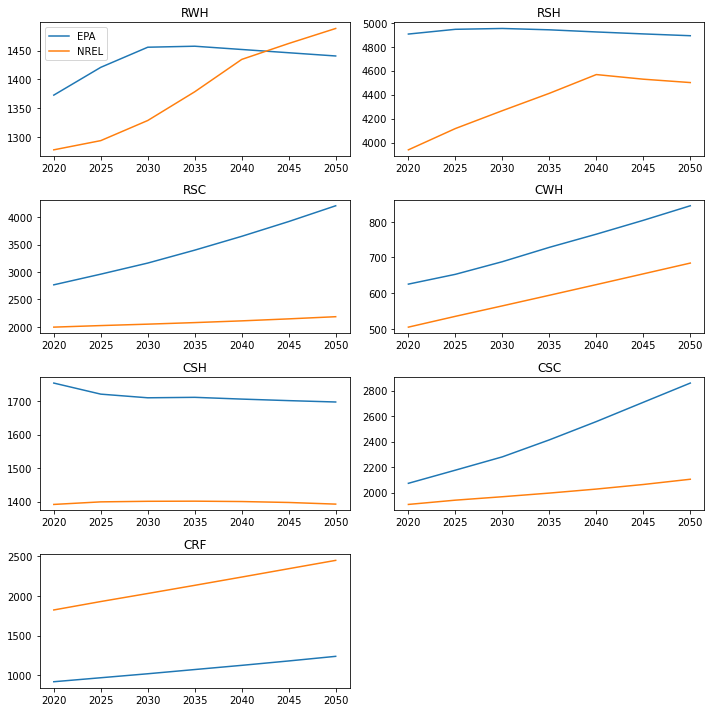

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
i=1
for sub in df_national_demands_merged.demand_comm.unique():
    if sub in ['CSC', 'CSH', 'CWH', 'CRF', 'RSC', 'RSH', 'RWH']:
        plt.subplot(4,2,i)
        df_plot = df_national_demands_merged[df_national_demands_merged.demand_comm==sub]
        plt.title(sub)
        plt.plot(df_plot.periods, df_plot.demand, label='EPA')
        plt.plot(df_plot.periods, df_plot.VALUE, label='NREL')
        if i==1:
            plt.legend()
        i+=1
plt.tight_layout()



In [27]:
df_temoa_mod_demands_all = pd.DataFrame()
for region in df_state_demands.Region.unique():
    df_temoa_mod_demands = df_national_demands.copy()
    df_temoa_mod_demands['regions'] = region
    df_nrel_demands = df_state_demands[df_state_demands.Region==region]
    df_temoa_mod_demands = df_temoa_mod_demands.merge(df_nrel_demands, right_on = ['SUBSECTOR', 'YEAR'], \
                                                     left_on = ['SUBSECTOR','periods'])
    df_temoa_mod_demands['demand'] *= df_temoa_mod_demands['regional_fraction']
    df_temoa_mod_demands_all = pd.concat([df_temoa_mod_demands_all, df_temoa_mod_demands[orig_cols]])

In [28]:
df_temoa_mod_demands[df_temoa_mod_demands.demand_comm=='RSH']

,regions,periods,demand_comm,demand,demand_units,demand_notes,SUBSECTOR,Region,YEAR,UNIT,VALUE,SUM,regional_fraction
7,NE,2020,RSH,930.990859,#PJ,NULL,RESIDENTIAL SPACE HEATING,NE,2020,MMBTU,7.085615e+08,3.733689e+09,0.189775
8,NE,2025,RSH,939.905064,#PJ,NULL,RESIDENTIAL SPACE HEATING,NE,2025,MMBTU,7.416354e+08,3.902152e+09,0.190058
9,NE,2030,RSH,942.323853,#PJ,NULL,RESIDENTIAL SPACE HEATING,NE,2030,MMBTU,7.693892e+08,4.043515e+09,0.190277
10,NE,2035,RSH,941.761468,#PJ,NULL,RESIDENTIAL SPACE HEATING,NE,2035,MMBTU,7.968420e+08,4.180790e+09,0.190596
11,NE,2040,RSH,938.868717,#PJ,NULL,RESIDENTIAL SPACE HEATING,NE,2040,MMBTU,8.255702e+08,4.329178e+09,0.190699
12,NE,2045,RSH,922.836410,#PJ,NULL,RESIDENTIAL SPACE HEATING,NE,2045,MMBTU,8.072997e+08,4.292582e+09,0.188069
13,NE,2050,RSH,906.632546,#PJ,NULL,RESIDENTIAL SPACE HEATING,NE,2050,MMBTU,7.906290e+08,4.265938e+09,0.185335


In [29]:
#this is the final csv file that is used to create the US_Regional.sqlite database elsewhere
df_temoa_mod_demands_all.to_csv('buildings_regional_demands_adjusted.csv')